In [8]:
import pandas as pd
import os
import re

# CSV 파일 읽기
df = pd.read_csv('raw_data.csv')

# MDM이 True인 데이터만 필터링
mdm_true_df = df[df['MDM'] == True]

# 'thing'과 'property'로 그룹화하여 'tag_description'을 이어붙이기 (NaN을 빈 문자열로 처리)
tag_description_concatenated = mdm_true_df.groupby(['thing', 'property'])['tag_description'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index()

# 'thing'과 'property'로 그룹화하여 'tag_name'을 이어붙이기 (NaN을 빈 문자열로 처리)
tag_name_concatenated = mdm_true_df.groupby(['thing', 'property'])['tag_name'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index()

# 'thing'과 'property'의 매핑 개수 계산
mapping_count = mdm_true_df.groupby(['thing', 'property']).size().reset_index(name='mapping_count')

# 세 개의 데이터프레임 병합: mapping_count, tag_description_concatenated, tag_name_concatenated
thing_property_grouped = pd.merge(mapping_count, tag_description_concatenated, on=['thing', 'property'])
thing_property_grouped = pd.merge(thing_property_grouped, tag_name_concatenated, on=['thing', 'property'])

# 'tag_description'에서 공백으로 분리된 토큰 수 계산
thing_property_grouped['td_token_count'] = thing_property_grouped['tag_description'].apply(lambda x: len(re.findall(r'\S+', x)))

# 'tag_description'에서 고유한 토큰 수 계산 (unique_token_count)
thing_property_grouped['unique_token_count'] = thing_property_grouped['tag_description'].apply(lambda x: len(set(re.findall(r'\S+', x))))

# 'thing'과 'property'에서 숫자를 '#'으로 대체하여 pattern 생성
thing_property_grouped['pattern'] = thing_property_grouped['thing'].str.replace(r'\d', '#', regex=True) + " " + thing_property_grouped['property'].str.replace(r'\d', '#', regex=True)

# 고유한 thing_property 조합의 총 개수 계산
total_thing_property_count = thing_property_grouped.shape[0]

# 저장 경로 지정
output_path = 'output/thing_property_grouped.csv'

# 디렉터리 생성 (존재하지 않으면)
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# 결과를 CSV 파일로 저장
thing_property_grouped.to_csv(output_path, index=False, encoding='utf-8-sig')

# 결과 출력
print(f"Concatenated data saved to {output_path}")
print(f"Total number of unique thing_property combinations: {total_thing_property_count}")


Concatenated data saved to output/thing_property_grouped.csv
Total number of unique thing_property combinations: 691


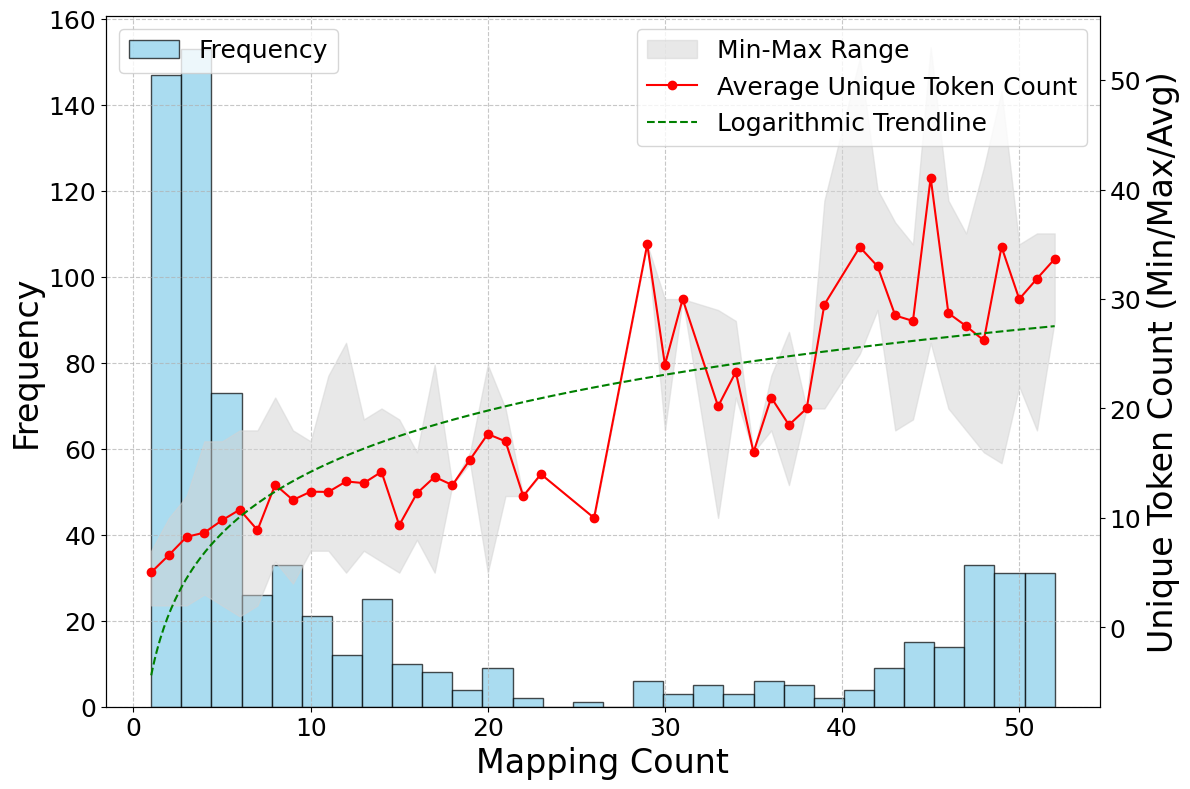

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Left axis: Plotting the histogram for mapping_count
fig, ax1 = plt.subplots(figsize=(12, 8))

# Histogram for mapping_count
ax1.hist(thing_property_grouped['mapping_count'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Mapping Count', fontsize=24, color='black')  # X-axis label with larger font
ax1.set_ylabel('Frequency', fontsize=24, color='black')      # Y-axis label with larger font
ax1.grid(True, linestyle='--', alpha=0.7)

# Set axis color to black
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')

# Make tick labels larger
ax1.tick_params(axis='x', colors='black', labelsize=18)
ax1.tick_params(axis='y', colors='black', labelsize=18)

# Right axis: Plotting unique_token_count min, max, and average
ax2 = ax1.twinx()

# Group by mapping_count to calculate min, max, and average of unique_token_count
grouped_token_stats = thing_property_grouped.groupby('mapping_count')['unique_token_count'].agg(['min', 'max', 'mean']).reset_index()

# Plot the min-max range as a shaded area
ax2.fill_between(grouped_token_stats['mapping_count'],
                 grouped_token_stats['min'],
                 grouped_token_stats['max'],
                 color='lightgray', alpha=0.5, label='Min-Max Range')

# Plot the average unique_token_count as a line
ax2.plot(grouped_token_stats['mapping_count'],
         grouped_token_stats['mean'],
         color='red', marker='o', linestyle='-', label='Average Unique Token Count')

ax2.set_ylabel('Unique Token Count (Min/Max/Avg)', fontsize=24, color='black')  # Larger font for right Y-axis label
ax2.tick_params(axis='y', colors='black', labelsize=18)

# Add legends
ax1.legend(['Frequency'], loc='upper left', fontsize=18)
ax2.legend(loc='upper right', fontsize=18)

# Add a logarithmic trendline
# Applying log to mapping_count for the trendline
log_mapping_count = np.log(grouped_token_stats['mapping_count'])

# Fit a linear model on the log of the mapping_count
z = np.polyfit(log_mapping_count, grouped_token_stats['mean'], 1)  # Linear fit on log-transformed data
p = np.poly1d(z)

# Generate x values and corresponding y values for the trendline
x_vals = np.linspace(grouped_token_stats['mapping_count'].min(), grouped_token_stats['mapping_count'].max(), 500)
log_x_vals = np.log(x_vals)
y_vals = p(log_x_vals)

# Plot the logarithmic trendline
ax2.plot(x_vals, y_vals, color='green', linestyle='--', label='Logarithmic Trendline')

# Add the trendline to the legend
ax2.legend(loc='upper right', fontsize=18)

plt.tight_layout()
plt.show()
